In [1]:
import torch
torch.manual_seed(2)

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


In [13]:
class System(torch.nn.Module):
    def __init__(self, x0, horizon):
        self.x0 = x0
        self.horizon = horizon
          # Initialize heating state to 0.5 (OFF)

    def step(self, x,u_bin, d = None, neural = True, hard = False):
        """if d is not None:
            u = d[:, 0:+1, :] + u"""
        
        
        x = 0.99*x + 2*u_bin - d

        self.u = u_bin.clone()
        return x
    
    def rollout(self, controller, tau = 1,d = None, hard = False, neural = True):

        x = d[:,0:1,:] if d is not None else self.x0.clone()
        xs = x.clone()
        us = torch.zeros(xs.shape[0],1,1)
        self.us_soft = torch.zeros(xs.shape[0],1,1)



        for t in range(1,self.horizon-1):

            u_bin = controller(x,d[:,t:t+1,:],tau = tau,  hard = hard)
            x = self.step(x, u_bin,d[:,t:t+1,:], neural=neural, hard=hard)

            xs = torch.cat((xs, x), 1)
            us = torch.cat((us, u_bin), 1)

            if hard:
                self.us_soft = torch.cat((self.us_soft, controller.u_soft), 1)

        return xs, us
    
class Dataset():    
    def __init__(self, x0, horizon,xmin,xmax):
        self.x0 = x0
        self.horizon = horizon
        self.batch_size = self.x0.shape[0]
        self.xmin = xmin
        self.xmax = xmax
    def generate_data(self):
        d = torch.zeros((self.batch_size, self.horizon, 1))
        d = torch.zeros((self.batch_size, self.horizon, 1))
        d[:, 0, :] = (self.xmax-self.xmin)*torch.rand((self.batch_size, 1))+self.xmin
        #d[:, 0, :] = 80

        # Sample one uniform value per batch in [0.3, 1.0]

        # Time indices from 70 to T-1
        for i in range(1, d.shape[1]-1):
            u = torch.rand((d.shape[0],1))*0.3
        
            d[:, i, :] = u

         
        return d


class Loss():
    def __init__(
        self, R, u_min, u_max, x_min,x_max,x_ref,peak = False, renewable_fossil_peak = False,
        alpha_xl=None, alpha_xh=None,
        loss_bound=None, sat_bound=None,
    ):
        
        self.peak = peak

        self.umin = u_min
        self.umax = u_max
        self.xmin = x_min
        self.xmax = x_max

        self.loss_bound = loss_bound
        self.sat_bound = sat_bound

        self.alpha_xl = alpha_xl
        self.alpha_xh = alpha_xh

        #Weight of the base lost
        self.R = R
        

        self.x_ref = x_ref


        #Create tariff over time vector
        high = [3]*12
        low = [1]*12
        self.tariff = torch.tensor(high+low)


    def forward(self, xs, us):      ## removed dxref
        """
        Compute loss.

        Args:
            - xs: tensor of shape (S, T, state_dim)
            - us: tensor of shape (S, T, in_dim)

        Return:
            - loss of shape (1, 1).
        """

        # batch
        x_batch = xs.reshape(*xs.shape,1)
        u_batch = us.reshape(*us.shape, 1)

        error = x_batch - self.x_ref
        # dxref = dxref.reshape(*dxref.shape, 1)

        # loss states = 1/T sum_{t=1}^T (x_t-xbar)^T Q (x_t-xbar)
        
        # loss control actions = 1/T sum_{t=1}^T u_t^T R u_t

        if self.peak:
            u_b = u_batch.clone()
            for i in range(13):
                u_b[:,i,:,:] = u_b[:,i,:,:]*10
            loss_u = torch.sum(u_b, 1) / x_batch.shape[1]    # average over the time horizon. shape = (S, 1, 1)
        
        else: 
            uTRu = self.R * torch.matmul(
                error.transpose(-1, -2),
                error
            )   # shape = (S, T, 1, 1)
            loss_u = torch.sum(uTRu, 1) / x_batch.shape[1] 

        # if self.renewable_fossil_peak:
        #     heat_demand =  [30,20, 25, 30, 35, 40, 50, 60, 70, 80, 100, 90, 80, 70, 60, 50, 60, 80, 100, 90, 80, 70, 50, 40]
        #     fossil_rescale = 0.1
        #     fossil_price = fossil_rescale * heat_demand

        #     renewable_avail = [1, 2, 3, 5, 7, 10, 13, 17, 20, 22, 24, 25, 25, 24, 22, 20, 17, 13, 10, 7, 5, 3, 2, 1]
        #     renewable_rescale = 0.1
        #     renewable_boundary = renewable_rescale * torch.tensor(renewable_avail)  # shape [24]

        #     u_b = u_batch.clone()

        #     # Reshape renewable_boundary to [1, 24, 1, 1] for broadcasting
        #     renewable_boundary = renewable_boundary.view(1, 24, 1, 1)

        #     # Subtract renewable_boundary from u_b
        #     u_delta_renewable = u_b - renewable_boundary

        #     u_surplus = torch.relu(u_delta_renewable)
            

        # upper bound on temperature loss
        if self.alpha_xh is None:
            loss_xh = 0
        else:
            loss_xh = self.alpha_xh * self.f_upper_bound_x(x_batch)       # shape = (S, 1, 1)

        # lower bound on temperature loss
        if self.alpha_xl is None:
            loss_xl = 0
        else:
            loss_xl = self.alpha_xl * self.f_lower_bound_x(x_batch) # shape = (S, 1, 1)

        self.l_xl = torch.sum(loss_xl, 0)/xs.shape[0]
        
        self.l_xh = torch.sum(loss_xh, 0)/xs.shape[0]

        # loss on switching pump ON/OFF, continuous or discrete or off
        switch_loss_mode = "off"
        if switch_loss_mode == "off":
            switch_loss = 0
        elif switch_loss_mode == "continuous" | "discrete":
            u_bool = u_batch >= 0.01
            switch_number = (u_bool[:, 1:, :, :] ^ u_bool[:, :-1, :, :]).float()
            if switch_loss_mode == "discrete":
                #discrete
                switch_penalty = switch_number
            if switch_loss_mode == "continuous":
                u_smooth = torch.sigmoid(u_batch)  # Output between 0 and 1
                # Compute the difference between consecutive time steps along the time dimension (dim=1)
                # This will give us the "change" between consecutive time steps
                # switch_penalty = torch.abs(u_smooth[:, 1:, :, :] - u_smooth[:, :-1, :, :])  # L1 difference
                # Optionally, use the L2 difference (squared difference) instead
                switch_penalty = (u_smooth[:, 1:, :, :] - u_smooth[:, :-1, :, :]).pow(2)  # L2 difference
            switch_switch_loss = switch_penalty.sum()
            alpha_switch = 0.07
            switch_loss = alpha_switch * switch_loss
            self.l_switch = torch.sum(switch_number.sum(), 0)

        # sum up all losses
        loss_val = loss_u + loss_xh + loss_xl           # + switch_loss          # shape = (S, 1, 1)

        # bound
        if self.sat_bound is not None:
            loss_val = torch.tanh(loss_val/self.sat_bound)  # shape = (*batch_dim, 1, 1)
        if self.loss_bound is not None:
            loss_val = self.loss_bound * loss_val           # shape = ((*batch_dim, 1, 1
        
        loss_val = torch.sum(loss_val, 0)/xs.shape[0]       # shape = (1, 1)
        
        return loss_val

    
    def f_upper_bound_x(self, x_batch): 
        """
        Args:
            - x_batched: tensor of shape (S, T, state_dim, 1)
        """

        
        delta = x_batch - self.xmax

        loss_bound = torch.relu(delta) ##
        # loss_bound = torch.nn.functional.softplus(delta, beta = 2.0) ##
        loss_xh = loss_bound.sum(1)/loss_bound.shape[1]
        return loss_xh.reshape(-1,1,1)



    def f_lower_bound_x(self, x_batch,s = True):

        delta = self.xmin - x_batch  

        loss_bound = torch.relu(delta) ##
        # loss_bound = torch.nn.functional.softplus(delta, beta = 2.0)
        if s == True: 
            loss_xl = loss_bound.sum(1)/loss_bound.shape[1]
            return loss_xl.reshape(-1,1,1)
        else: 
            return loss_bound


## Simple pure MLP (no binary)


In [52]:
class Controller(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # output logit
        )


    def forward(self, x,d, tau=1.0, hard=False):
        input = torch.cat((x,d), dim=2)

       
        u_soft = torch.sigmoid(self.net(input)/tau)  # shape: [batch, 1]
        self.u_soft = u_soft.clone()    
        if hard == True:
            u = (u_soft > 0.5).float()

            return u
        else:
            return u_soft
        
      

Epoch 0, Loss: 50.9401
Epoch 250, Loss: 1.1649
Epoch 500, Loss: 1.0082
Epoch 750, Loss: 1.0016
Epoch 1000, Loss: 0.9989
Epoch 1250, Loss: 0.9970
Epoch 1500, Loss: 0.9956
Epoch 1750, Loss: 0.9946
Epoch 2000, Loss: 0.9939
Epoch 2250, Loss: 0.9934
Test Loss: 1.1268


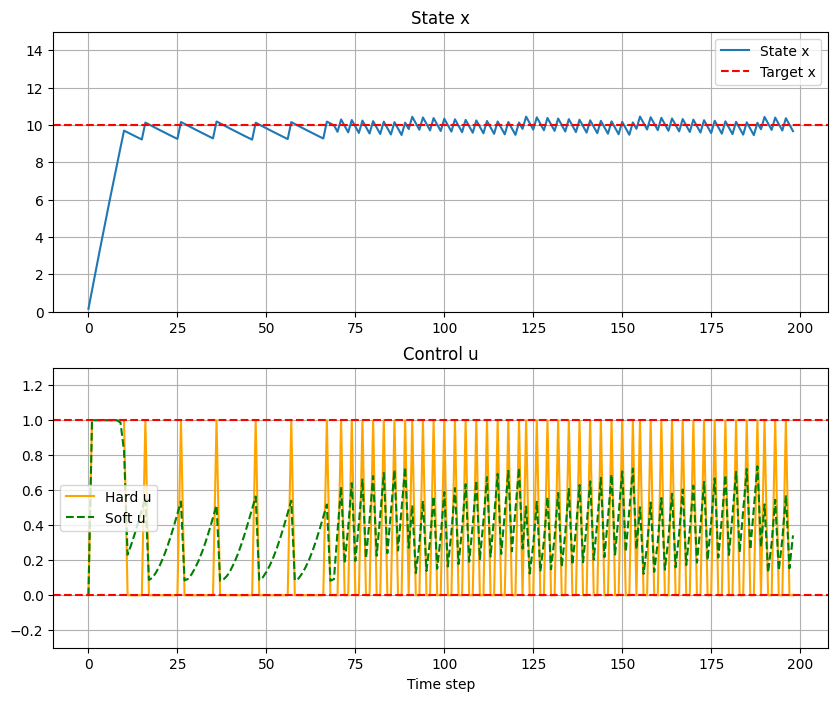

In [12]:
nb = 400

x0 = torch.zeros((nb,1,1))
#x0[0,0,0] = 10
x_target = 10

horizon = 200



sys = System(x0,horizon)

controller = Controller()
data = Dataset(x0, horizon)
d = data.generate_data()
test_d = data.generate_data()

tau_0 = 1.0
alpha = 0.995
tau_min = 0.1

best_loss = float('inf')
best_params = None

num_epochs = 2500
log_epochs = num_epochs // 10
optimizer = torch.optim.Adam(controller.parameters(), lr=0.001) 

for epoch in range(num_epochs):
    optimizer.zero_grad()
    #tau = max(tau_0 * (alpha ** epoch), tau_min)
    tau = 0.1
    xs, us = sys.rollout(controller, tau = tau,d = d, hard = False, neural = True)

    loss = torch.mean((xs - x_target)**2) 

    loss.backward()
    optimizer.step()

    if epoch % log_epochs == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = controller.state_dict()

# Load the best parameters
controller.load_state_dict(best_params)
with torch.no_grad():
    x_log, u_log = sys.rollout(controller,tau = tau,d = test_d, hard=True)

loss = torch.mean((x_log- x_target)**2) 
print(f"Test Loss: {loss.item():.4f}")
x_log_1 = x_log.clone()
u_log_1 = sys.us_soft
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(x_log[0,:,:].detach().numpy(), label='State x')
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].set_title('State x')
ax[0].set_ylim(0, 15)
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()




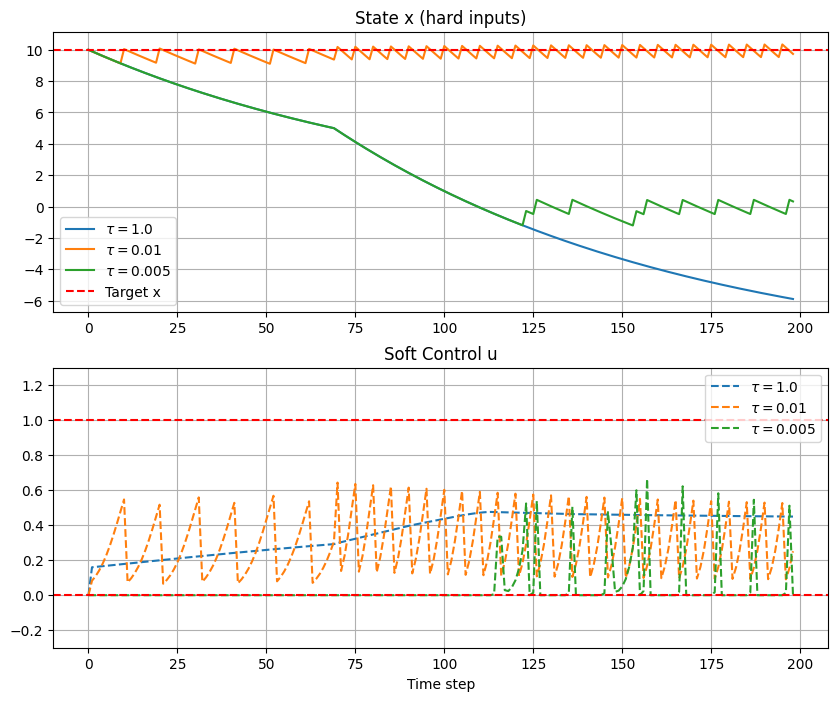

In [64]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(x_log_1[0,:,:].detach().numpy(), label=r'$\tau=1.0$') 
ax[0].plot(x_log_01[0,:,:].detach().numpy(), label=r'$\tau=0.01$')
ax[0].plot(x_log_001[0,:,:].detach().numpy(), label=r'$\tau=0.005$')
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].set_title('State x (hard inputs)')
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log_1.detach().numpy(),linestyle="--", label=r'$\tau=1.0$') 
ax[1].plot(u_log_01.detach().numpy(), linestyle="--", label=r'$\tau=0.01$')
ax[1].plot(u_log_001.detach().numpy(), linestyle="--", label=r'$\tau=0.005$')
ax[1].set_title('Soft Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()


## Gumbel softmax

In [7]:
class Controller_Gumbel(nn.Module):
    def __init__(self,xbase = 1.0,dbase = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # output logit
        )
        self.xbase = xbase
        self.dbase = dbase


    def forward(self, x,d, tau=1.0, hard=False):
        x = x/self.xbase
        d = d/self.dbase
        input = torch.cat((x,d), dim=2)
        
        logits = self.net(input)

        u = torch.rand_like(logits)

        #g = -torch.log(-torch.log(u))
        
        n = torch.log(u)-torch.log(1-u)
        u_soft = torch.sigmoid((logits+n)/tau)  # shape: [batch, 1]

        self.u_soft = u_soft.clone()    
        if hard == True:
            u_hard = (u_soft > 0.5).float()
            
            return u_hard
        else:
            return u_soft

In [8]:
nb = 400
x0 = torch.zeros((nb,1,1))
#x0[0,0,0] = 10
x_target = 80

horizon = 200

x_min = 70
x_max = 90


data = Dataset(x0, horizon,x_min,x_max)
d = data.generate_data()
test_d = data.generate_data()

Epoch 0, Loss: 772.0411
Epoch 250, Loss: 10.2628
Epoch 500, Loss: 10.0013
Epoch 750, Loss: 10.1213
Epoch 1000, Loss: 10.2882
Epoch 1250, Loss: 9.7915
Epoch 1500, Loss: 9.8379
Epoch 1750, Loss: 10.1081
Epoch 2000, Loss: 9.4754
Epoch 2250, Loss: 8.8236
Test Loss: 8.0102


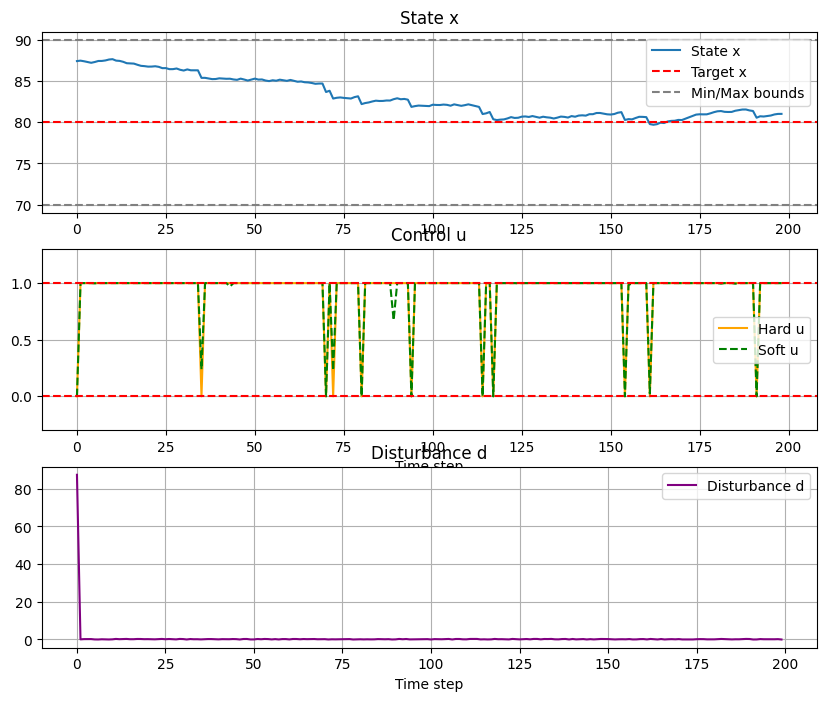

In [9]:




sys = System(x0,horizon)


controller = Controller_Gumbel(xbase = x_max)

loss_fn = Loss(R=3.0, u_min=0.0, u_max=1.0, x_min=x_min, x_max=x_max,x_ref=x_target,
    alpha_xl=0.0, alpha_xh=0.0,
    peak=False
)

tau_0 = 1.0
alpha = 0.995
tau_min = 0.1

best_loss = float('inf')
best_params = None

num_epochs = 2500
log_epochs = num_epochs // 10
optimizer = torch.optim.Adam(controller.parameters(), lr=0.001) 

for epoch in range(num_epochs):
    optimizer.zero_grad()

    tau = max(tau_0 * (alpha ** epoch), tau_min)
    #tau = 0.1
    xs, us = sys.rollout(controller, tau = tau,d = d, hard = False, neural = True)

    loss = torch.mean((xs - x_target)**2) 
    #loss = loss_fn.forward(xs, us)
    loss.backward()
    optimizer.step()

    if epoch % log_epochs == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_params = controller.state_dict()

# Load the best parameters
controller.load_state_dict(best_params)
with torch.no_grad():
    x_log, u_log = sys.rollout(controller,tau = tau,d = d, hard=True)
    loss = loss_fn.forward(x_log, u_log)

loss = torch.mean((x_log- x_target)**2) 
print(f"Test Loss: {loss.item():.4f}")
x_log_01 = x_log.clone()
u_log_01 = sys.us_soft
fig, ax = plt.subplots(3,1, figsize=(10,8))
ax[0].plot(x_log[0,:,:].detach().numpy(), label='State x')
"""ax[0].plot(x_log[1,:,:].detach().numpy(), label='State x')
ax[0].plot(x_log[2,:,:].detach().numpy(), label='State x')"""
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].axhline(y=x_min, color='grey', linestyle='--', label='Min/Max bounds')
ax[0].axhline(y=x_max, color='grey', linestyle='--')
ax[0].set_title('State x')
#ax[0].set_ylim(0, 15)
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()

ax[2].plot(d[0,:,0].detach().numpy(), label='Disturbance d', color='purple')
ax[2].set_title('Disturbance d')
ax[2].set_xlabel('Time step')
ax[2].legend()
ax[2].grid()




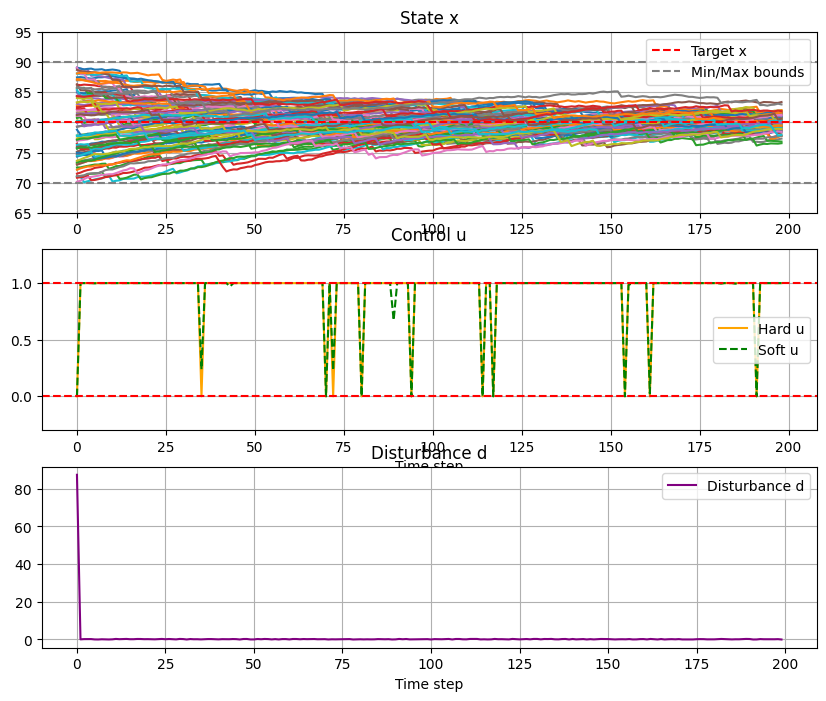

In [12]:
fig, ax = plt.subplots(3,1, figsize=(10,8))
for i in range(80):
    ax[0].plot(x_log[i,:,:].detach().numpy())
ax[0].axhline(y=x_target, color='r', linestyle='--', label='Target x')
ax[0].axhline(y=x_min, color='grey', linestyle='--', label='Min/Max bounds')
ax[0].axhline(y=x_max, color='grey', linestyle='--')
ax[0].set_title('State x')
ax[0].set_ylim(65, 95)
ax[0].legend()
ax[0].grid()

ax[1].plot(u_log[0,:,:].detach().numpy(), label='Hard u', color='orange')
ax[1].plot(sys.us_soft[0,:,:].detach().numpy(), label='Soft u', color='green', linestyle='--')
ax[1].set_title('Control u')
ax[1].set_xlabel('Time step')
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=1, color='r', linestyle='--')
ax[1].set_ylim(-0.3, 1.3)
ax[1].legend()
ax[1].grid()

ax[2].plot(d[0,:,0].detach().numpy(), label='Disturbance d', color='purple')
ax[2].set_title('Disturbance d')
ax[2].set_xlabel('Time step')
ax[2].legend()
ax[2].grid()

In [45]:
losses = []
for rollout in range(5):
    loss_in = []
    sys = System(x0,horizon)

    controller = Controller_Gumbel()


    tau_0 = 1.0
    alpha = 0.995
    tau_min = 0.1

    best_loss = float('inf')
    best_params = None

    num_epochs = 2500
    log_epochs = num_epochs // 10
    optimizer = torch.optim.Adam(controller.parameters(), lr=0.001) 
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        tau = max(tau_0 * (alpha ** epoch), tau_min)
        #tau = 0.1
        xs, us = sys.rollout(controller, tau = tau,d = d, hard = False, neural = True)

        loss = torch.mean((xs - x_target)**2) 

        loss.backward()
        optimizer.step()
        
        if epoch % log_epochs == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params = controller.state_dict()
        if epoch %10 == 0:
            loss_in.append(loss.item())
    losses.append(loss_in)
        

Epoch 0, Loss: 164.9682
Epoch 250, Loss: 3.4552
Epoch 500, Loss: 1.3470
Epoch 750, Loss: 0.7783
Epoch 1000, Loss: 0.5669
Epoch 1250, Loss: 0.4755
Epoch 1500, Loss: 0.4420
Epoch 1750, Loss: 0.3896
Epoch 2000, Loss: 0.3620
Epoch 2250, Loss: 0.3291
Epoch 0, Loss: 331.1750
Epoch 250, Loss: 4.6004
Epoch 500, Loss: 1.2825
Epoch 750, Loss: 0.7230
Epoch 1000, Loss: 0.5534
Epoch 1250, Loss: 0.4682
Epoch 1500, Loss: 0.4209
Epoch 1750, Loss: 0.3937
Epoch 2000, Loss: 0.3480
Epoch 2250, Loss: 0.3284
Epoch 0, Loss: 297.7442
Epoch 250, Loss: 6.5426
Epoch 500, Loss: 2.8777
Epoch 750, Loss: 1.4414
Epoch 1000, Loss: 0.9580
Epoch 1250, Loss: 0.7784
Epoch 1500, Loss: 0.6958
Epoch 1750, Loss: 0.6208
Epoch 2000, Loss: 0.5233
Epoch 2250, Loss: 0.4293
Epoch 0, Loss: 1289.3289
Epoch 250, Loss: 5.7064
Epoch 500, Loss: 1.9638
Epoch 750, Loss: 1.0984
Epoch 1000, Loss: 0.7633
Epoch 1250, Loss: 0.6610
Epoch 1500, Loss: 0.5423
Epoch 1750, Loss: 0.4760
Epoch 2000, Loss: 0.4282
Epoch 2250, Loss: 0.3786
Epoch 0, Loss: 

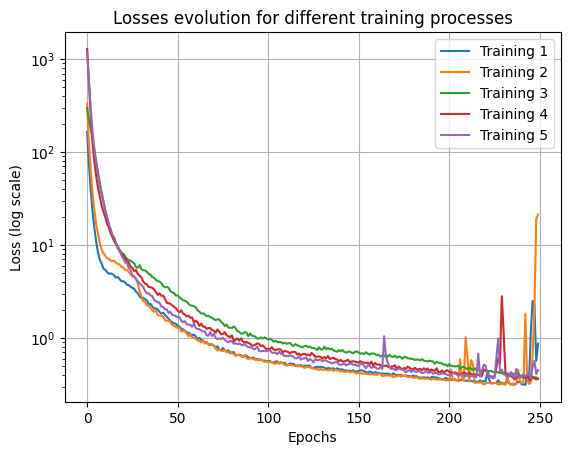

In [48]:
for i in range(len(losses)):
    plt.plot(losses[i], label=f'Training {i+1}')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Losses evolution for different training processes')
plt.legend()
plt.grid()
plt.show()
